# imports

In [127]:
#imports
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary
#import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm import tqdm

import cv2
from PIL import Image

from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Preliminary preparation

## loading text data

In [ ]:
data_PATH="D:\\download\\PD project\\datasets\\ICDAR 2013 - Gender Identification Competition Dataset"
image_PATH=data_PATH+"\\unzipped"
models_path=".\outputs\models"
train_df_complete = pd.read_csv(os.path.join(data_PATH, "train\\train.csv"))

In [46]:
train_df_complete.head(10)

,writer,page_id,language,same_text,tortuosityHist10[0],tortuosityHist10[1],tortuosityHist10[2],tortuosityHist10[3],tortuosityHist10[4],tortuosityHist10[5],...,directions_hist1a2a3a4a5a6a7a8a9a10_220[210],directions_hist1a2a3a4a5a6a7a8a9a10_220[211],directions_hist1a2a3a4a5a6a7a8a9a10_220[212],directions_hist1a2a3a4a5a6a7a8a9a10_220[213],directions_hist1a2a3a4a5a6a7a8a9a10_220[214],directions_hist1a2a3a4a5a6a7a8a9a10_220[215],directions_hist1a2a3a4a5a6a7a8a9a10_220[216],directions_hist1a2a3a4a5a6a7a8a9a10_220[217],directions_hist1a2a3a4a5a6a7a8a9a10_220[218],directions_hist1a2a3a4a5a6a7a8a9a10_220[219]
0,1,1,Arabic,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002457,0.002633,0.002698,0.002929,0.003014,0.003225,0.003572,0.003957,0.004232,0.004804
1,1,2,Arabic,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002498,0.002641,0.002836,0.002999,0.003246,0.003456,0.003709,0.003994,0.004308,0.004706
2,1,3,English,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002090,0.002440,0.002831,0.003078,0.003438,0.003732,0.004100,0.004329,0.004687,0.004879
3,1,4,English,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002435,0.002823,0.003117,0.003441,0.003788,0.004056,0.004285,0.004527,0.004843,0.005085
4,2,1,Arabic,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002465,0.002724,0.003079,0.003305,0.003425,0.003403,0.003450,0.003626,0.003977,0.004547
5,2,2,Arabic,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002535,0.002808,0.002942,0.003151,0.003247,0.003246,0.003433,0.003516,0.003787,0.004377
6,2,3,English,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002887,0.003271,0.003569,0.003793,0.004049,0.004214,0.004339,0.004598,0.004874,0.005211
7,2,4,English,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002946,0.003295,0.003569,0.003846,0.004083,0.004329,0.004566,0.004850,0.005092,0.005397
8,3,1,Arabic,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.002245,0.002325,0.002383,0.002515,0.002725,0.003046,0.003304,0.003629,0.004037,0.004564
9,3,2,Arabic,1,0.92875,0.004071,0.001876,0.0,0.018031,0.025427,...,0.002179,0.002267,0.002385,0.002550,0.002723,0.002836,0.003049,0.003374,0.003757,0.004354


## loading sex data

the number of males is 139 while the number of females is 143. There are no missing sex labels.

In [ ]:
sex_df = pd.read_csv(os.path.join(data_PATH, "train_answers.csv"),delimiter=',')
sex_df.head(15)

,writer,male
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
5,6,1
6,7,1
7,8,1
8,9,0
9,10,1


In [48]:
# Get the counts of each unique value in the "male" column
male_counts = sex_df['male'].value_counts(dropna=False)

# Print the counts
print("Number of times 'male' is 0:", male_counts.get(0, 0))
print("Number of times 'male' is 1:", male_counts.get(1, 0))
print("Number of times 'male' is something else:", len(sex_df) - male_counts.get(0, 0) - male_counts.get(1, 0))

Number of times 'male' is 0: 143
Number of times 'male' is 1: 139
Number of times 'male' is something else: 0


## end to end

### prepare dataframe

Carico il dataset di training: ha 1128 righe -> 282 scrittori 
Ho verificato che: 
    1) gli id scrittori sono effettivamente 282 
    2) page_id ha 4 valori categorici
    3) linguaggio è una variabile binaria: 0 se arabo, 1 se non arabo
    4) same_text è una variabile binaria
Ho verificato che nessuna di queste colonne ha dei missing values
Ho verificato che per ogni scrittore sono presenti sia same_text=1 che same_text=0 (idem per la lingua)

same_text=1 indica che il testo è lo stesso per tutti gli scrittori. Se invece same_text=0 -> il testo varia da scrittore a scrittore. Eg il testo in arabo con same_text=0 è lo stesso testo in arabo per tutti gli scrittori. 
page_id e same_text danno informazione ridondante (page id=1 ci dice già che il testo è in inglese e same non è zero)

rimuovo page_id, creo una variabile per dire arabo/non arabo, tengo same
devo convertire la colonna language a intero/dummy per avere arabo/non arabo poichè non è bianria ->

isEng: 0 se non è inglese, 1 se è inglese
same: 1 se è la stessa per scrittori diversi


In [49]:
selected_columns = ['writer', 'language', 'same_text']
train_df = train_df_complete[selected_columns]

# Convert the 'language' column to binary columns
language_dummies = pd.get_dummies(train_df['language'], drop_first=True)

# Add the binary column to the dataframe
train_df['isEng'] = language_dummies.iloc[:, 0].astype(int)

# Drop the original 'language' column
train_df.drop(columns=['language'], inplace=True)

# Display the updated dataframe
train_df.head(10)

C:\Users\burtm\AppData\Local\Temp\ipykernel_23236\4054552359.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['isEng'] = language_dummies.iloc[:, 0].astype(int)
C:\Users\burtm\AppData\Local\Temp\ipykernel_23236\4054552359.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['language'], inplace=True)


,writer,same_text,isEng
0,1,0,0
1,1,1,0
2,1,0,1
3,1,1,1
4,2,0,0
5,2,1,0
6,2,0,1
7,2,1,1
8,3,0,0
9,3,1,0


In [50]:
def check_if_both(train_df, column_name='same_text'):
    # Group by writer and check if both same_text=1 and same_text=0 are present
    writer_groups = train_df.groupby('writer')[column_name].nunique()

    # Filter writers that do not have both same_text=1 and same_text=0
    writers_missing_both = writer_groups[writer_groups != 2]

    if writers_missing_both.empty:
        print(f"All writers have both {column_name}=1 and {column_name}=0.")
    else:
        print(f"The following writers do not have {column_name}=1 and {column_name}=0")
        print(writers_missing_both)
check_if_both(train_df)
check_if_both(train_df, column_name='isEng')

All writers have both same_text=1 and same_text=0.
All writers have both isEng=1 and isEng=0.


I set the probability of being in the training set as p_train -> 90% of data will be in the training set

I create a dataframe that associate 0 or 1 with that probability to each writer. I then merge with the previous dataframe so that i have a df that can be used to easily separate in arab/non arab, same/non same and train/val

In [51]:
# Set the probability of being 0
p_train = 0.9
N=282

# Create a dataframe with writer column from 1 to 282
writers_df = pd.DataFrame({'writer': np.arange(1, N+1)})

# Add a train column that is randomly 0 or 1 with probability p of being 0
writers_df['train'] = np.random.choice([0, 1], size=len(writers_df), p=[1-p_train, p_train])

# Merge with the train_df dataframe on the writer column
train_df = train_df.merge(writers_df, on='writer', how='left')

# Display the dataframe
train_df.head()

,writer,same_text,isEng,train
0,1,0,0,1
1,1,1,0,1
2,1,0,1,1
3,1,1,1,1
4,2,0,0,1


Create a list of the folders from which to load data.

Check that in the folder paths you have the same writers, with the same number of pages etc .. -> I need to have all the writers from 1 to 282 each with 4 pages -> OK

After checking that everything is ok i can simply add the filenames to the train_df datarame -> i will be able to load conditionally based on the same, isEng and train columns 

In [52]:
folder_names = [folder for folder in os.listdir(image_PATH) if os.path.isdir(os.path.join(image_PATH, folder))]
# Extract the X part from the folder names
x_values = [int(folder.split('_')[0]) for folder in folder_names]

# Sort both lists based on the X values
sorted_indices = sorted(range(len(x_values)), key=lambda k: x_values[k])
folder_names = [folder_names[i] for i in sorted_indices]
x_values = [x_values[i] for i in sorted_indices]
print(folder_names)

['1_50', '51_100', '101_150', '151_200', '201_250', '251_300']


In [53]:
# Loop through each directory and collect image file paths for labeled images only
image_dirs = [os.path.join(image_PATH, folder) for folder in folder_names]
writers = []
isEng = []
same_text = []
file_names = []

for image_dir in image_dirs:
    for f in os.listdir(image_dir):
        if f.endswith('.jpg'):
            base_name = os.path.splitext(f)[0]  # Remove extension
            parts = base_name.split('_')

            if len(parts) != 2:
                continue  # Skip files that don't follow the expected pattern

            index, version = parts

            if int(version)>2:
                isEng.append(1)
            else:
                isEng.append(0)
            if int(version)%2==0:
                same_text.append(1)
            else:
                same_text.append(0)
            file_names.append(os.path.join(image_dir,f))
            writers.append(int(index))

# Create a dataframe from the extracted index and version values
train_file_df = pd.DataFrame({'writer': writers, 'isEng': isEng, 'same_text': same_text,'file_name':file_names})

# Display the dataframe
print(train_file_df['writer'].nunique())

'''print(train_file_df['writer'].min())
print(train_file_df['writer'].max())
# Check which writer values are missing in the interval 1-300
all_writers = set(range(1, 301))
present_writers = set(train_file_df['writer'].unique())
missing_writers = all_writers - present_writers

print(f"Missing writers in the interval 1-300: {sorted(missing_writers)}")'''

check_if_both(train_file_df,column_name='same_text')
check_if_both(train_file_df, column_name='isEng')


300
All writers have both same_text=1 and same_text=0.
All writers have both isEng=1 and isEng=0.


In [54]:
print(train_file_df.head(10))

   writer  isEng  same_text                                          file_name
0       1      0          0  D:\download\PD project\datasets\ICDAR 2013 - G...
1       1      0          1  D:\download\PD project\datasets\ICDAR 2013 - G...
2       1      1          0  D:\download\PD project\datasets\ICDAR 2013 - G...
3       1      1          1  D:\download\PD project\datasets\ICDAR 2013 - G...
4       2      0          0  D:\download\PD project\datasets\ICDAR 2013 - G...
5       2      0          1  D:\download\PD project\datasets\ICDAR 2013 - G...
6       2      1          0  D:\download\PD project\datasets\ICDAR 2013 - G...
7       2      1          1  D:\download\PD project\datasets\ICDAR 2013 - G...
8       3      0          0  D:\download\PD project\datasets\ICDAR 2013 - G...
9       3      0          1  D:\download\PD project\datasets\ICDAR 2013 - G...


In [55]:
print(train_file_df['file_name'][0])

D:\download\PD project\datasets\ICDAR 2013 - Gender Identification Competition Dataset\unzipped\1_50\0001_1.jpg


In [56]:
# Merge the file_name column to the train_df dataframe based on the writer column
train_df = train_df.merge(train_file_df, on=['isEng','writer','same_text'], how='left')

# Display the updated dataframe
train_df.head(10)

,writer,same_text,isEng,train,file_name
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
1,1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
2,1,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
3,1,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
4,2,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
5,2,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
6,2,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
7,2,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
8,3,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
9,3,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...


In [57]:
# Merge the file_name column to the train_df dataframe based on the writer column
train_df = train_df.merge(sex_df, on=['writer'], how='left')

# Display the updated dataframe
train_df.head(10)

,writer,same_text,isEng,train,file_name,male
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
1,1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
2,1,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
3,1,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
4,2,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
5,2,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
6,2,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
7,2,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
8,3,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
9,3,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0


In [58]:
# Filter the rows where train is 0
train_0_df = train_df[train_df['train'] == 0]

# Count the number of rows
train_0_count = train_0_df.shape[0]

print(f"Number of rows where train=0: {train_0_count}")

Number of rows where train=0: 140


### define dataloaders and dataframes (standard)

I import the necessary libraries and define the transformation to apply to the images while loading

transforms.Resize is used to resize an input image to a specified size. The first argument, 256, indicates the desired size for the smaller edge of the image. The max_size parameter, set to 512, ensures that the larger edge of the image does not exceed 512 pixels. This resizing operation maintains the aspect ratio of the original image, preventing distortion that could occur if the image were stretched or compressed disproportionately

I can specify which column to use as label column -> if i select isEng that will be the label column. If i use isMale this will be the label column ..

In [59]:
# Define the transformations for the images
transform = transforms.Compose([
    #transforms.Resize(256, max_size=512), 
    transforms.Resize((256, 256)),
    transforms.ToTensor()           # Convert the images to tensors
])

I create a custom data loader that takes a df and save each image with the corresponding label (0 or 1), and writer (1 to max_writer). The dataframe has a column with the path_names

The collate function is applied while creating the dataframe to pad the images to a squared aspect ratio

In [60]:
def pad_collate_fn(batch):
    """
    Pads images in a batch to match the largest image dimensions.
    """
    images = [item['image'] for item in batch]
    max_height = max(img.shape[1] for img in images)  # Find max height
    max_width = max(img.shape[2] for img in images)   # Find max width

    # Pad all images to the max dimensions in the batch
    padded_images = [
        F.pad(img, (0, 0, max_width - img.shape[2], max_height - img.shape[1])) for img in images
    ]

    # Stack images into a batch tensor
    batch_images = torch.stack(padded_images)

    # Keep other data (index, version, etc.)
    writers = torch.tensor([item['writer'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])  # Keeping labels in a list

    return {
        'image': batch_images,
        'writer': writers,
        'label': labels
    }


class CustomImageDataset(Dataset):
    def __init__(self, df,label_column, transform=None):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        #self.label_column=label_column
        self.image_files = df['file_name'].tolist()
        self.img_labels = df[label_column].tolist()
        self.img_writers = df['writer'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        writer=self.img_writers[idx]
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'writer': int(writer),
            'label': label
        }

In [61]:
# Initialize the dataset and dataloader
example_dataset = CustomImageDataset(train_df[(train_df['train']==1) & (train_df['writer']<=32)], label_column='male',transform=transform)
#example_dataloader = DataLoader(example_dataset, batch_size=16, shuffle=True,collate_fn=pad_collate_fn)
example_dataloader = DataLoader(example_dataset, batch_size=16, shuffle=True)

# Example usage
'''for batch in dataloader:
    images = batch['image']
    indices = batch['index']
    versions = batch['version']
    filenames = batch['filename']
    #print(filenames, indices, versions)'''

"for batch in dataloader:\n    images = batch['image']\n    indices = batch['index']\n    versions = batch['version']\n    filenames = batch['filename']\n    #print(filenames, indices, versions)"

### define dataloaders and dataframes (patches)

In [128]:
# Define the transformations for the images
patch_transform = transforms.Compose([
    #transforms.Resize(256, max_size=512), 
    transforms.Resize((256, 256)),
    transforms.ToTensor()           # Convert the images to tensors
])

In [129]:
def extract_patches(image,gw=5,n_cc=10):
    """Splits image into grid patches and checks for text presence."""
    image_gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    h, w = image_gray.shape
    patch_w = w // gw
    patch_h = patch_w
    gh= h // patch_h
    
    valid_patches = []
    
    for i in range(gh):
        for j in range(gw):
            x1, y1 = j * patch_w, i * patch_h
            x2, y2 = x1 + patch_w, y1 + patch_h
            patch = image_gray[y1:y2, x1:x2]
            
            # Check for text using connected components
            _, binary = cv2.threshold(patch, 180, 255, cv2.THRESH_BINARY_INV)
            num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary)
            
            if num_labels > n_cc:  # More than 1 means text is present
                #patch_rgb = image.crop((x1, y1, x2, y2))  # Extract RGB patch
                valid_patches.append((x1, y1, x2, y2,num_labels))
    
    return valid_patches


In [130]:
def process_row(row):
    image = Image.open(row["file_name"])  # Open the image
    #print(row["file_name"])
    patches = extract_patches(image,gw=5,n_cc=10)  # Extract patches
    
    # Create a new row for each patch
    new_rows = []
    for (x, y, x2, y2,n_cc) in patches:
        new_row = row.copy()
        new_row["x"], new_row["y"], new_row["x2"], new_row["y2"],new_row["n_cc"] = x, y, x2, y2, n_cc
        new_rows.append(new_row)
    
    return new_rows

#process_row(train_df.iloc[0])
# Apply function to each row and explode the list
train_df_expanded = pd.DataFrame(sum(train_df.apply(process_row, axis=1), []))

train_df_expanded.head()


,writer,same_text,isEng,train,file_name,male,x,y,x2,y2,n_cc
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,0,493,493,986,111
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,493,493,986,986,96
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,986,493,1479,986,90
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1479,493,1972,986,99
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1972,493,2465,986,99


In [131]:
#i select the m patches per writer that have the highest number of cc
m=10
train_df_expanded_sorted = train_df_expanded.sort_values(by='n_cc', ascending=False)
train_df_expanded = train_df_expanded_sorted.groupby('writer').head(m)   # Select top m patches per writer
#If a group (i.e., a specific 'writer') in the DataFrame has fewer than m rows, 
# the head(m) method will simply return all the rows available for that group. It does not raise an error or fill in additional rows


In [132]:
len(train_df_expanded)/282

10.0

In [84]:
class CustomPatchDataset(Dataset):
    def __init__(self, df, label_column,transform=None):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = df['file_name'].tolist()
        self.img_labels = df[label_column].tolist()
        self.img_writers = df['writer'].tolist()
        self.x1 = df['x'].tolist()
        self.y1 = df['y'].tolist()
        self.x2 = df['x2'].tolist()
        self.y2 = df['y2'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        x1=self.x1[idx]
        y1=self.y1[idx]
        x2=self.x2[idx]
        y2=self.y2[idx]
        image = Image.open(img_path).convert("RGB")
        patch = image.crop((x1, y1, x2, y2))
        writer=self.img_writers[idx]
        label = self.img_labels[idx]

        if self.transform:
            patch = self.transform(patch)

        return {
            'image': patch,
            'writer': int(writer),
            'label': label
        }

In [85]:
# Initialize the dataset and dataloader
patch_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==1) & (train_df_expanded['writer']<=32)], 
                                   label_column="male",transform=transform)
#example_dataloader = DataLoader(example_dataset, batch_size=16, shuffle=True,collate_fn=pad_collate_fn)
patch_dataloader = DataLoader(patch_dataset, batch_size=16, shuffle=True)

In [74]:
print(len(train_df_expanded))

405


### visualizing preprocessed batch

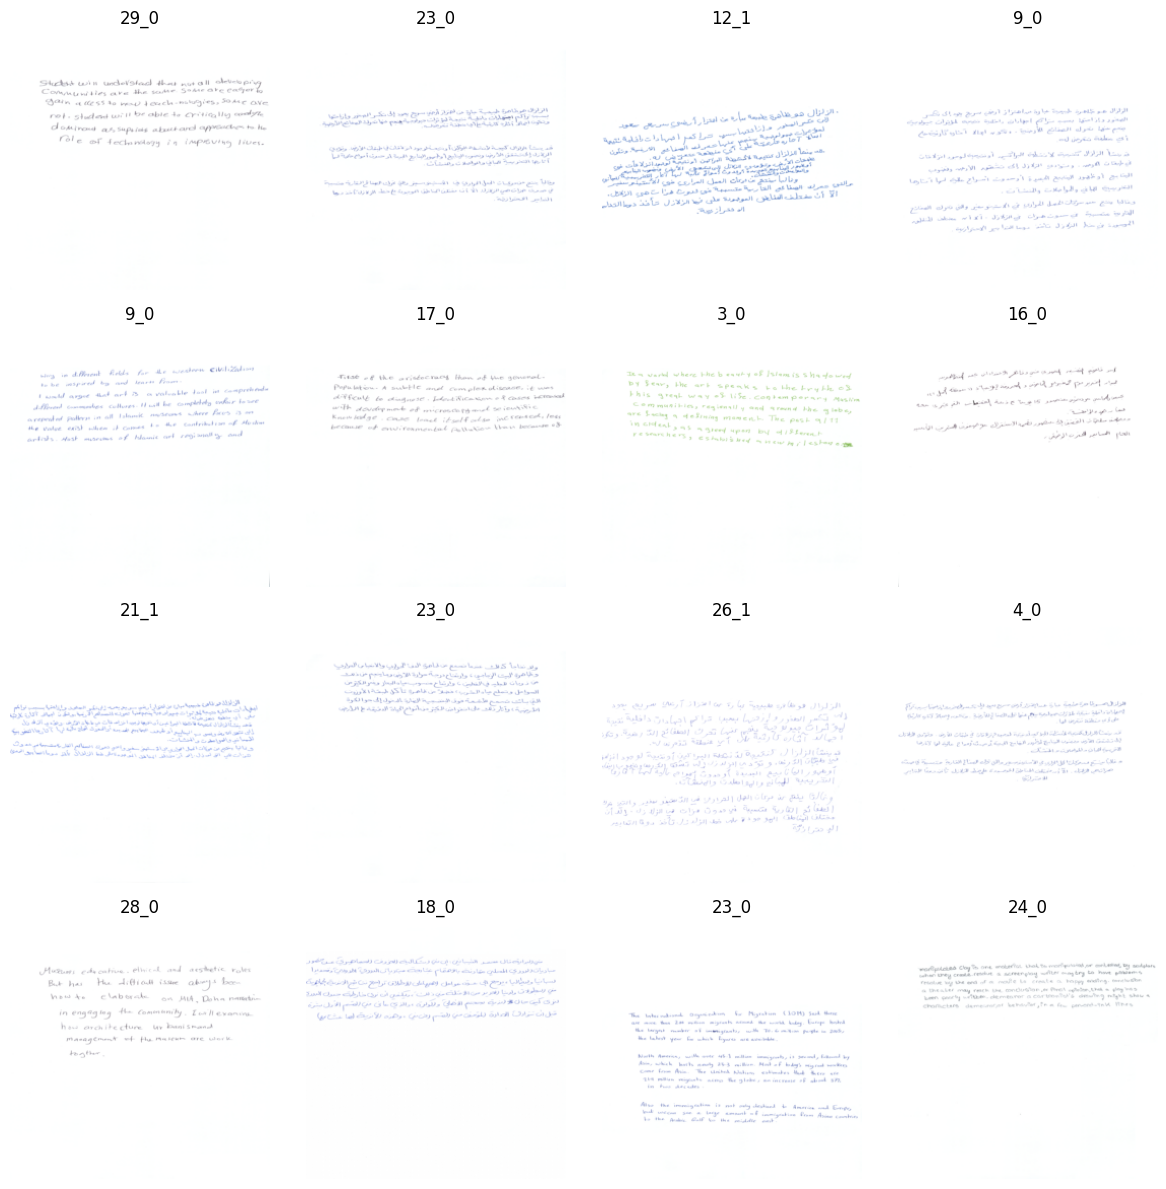

In [75]:
# Function to show a batch of images
def show_images(images, writers, labels, save_path=None):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for img, ax, writer, label in zip(images, axes, writers, labels):
        img = img.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(img)
        ax.set_title(str(int(writer))+'_'+str(int(label)))
        ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Show and save the batch of images

# Create an iterator
data_iter = iter(example_dataloader)
# Get a single batch
batch = next(data_iter)
show_images(batch['image'], batch['writer'], batch['label'], save_path='batch_images.png')

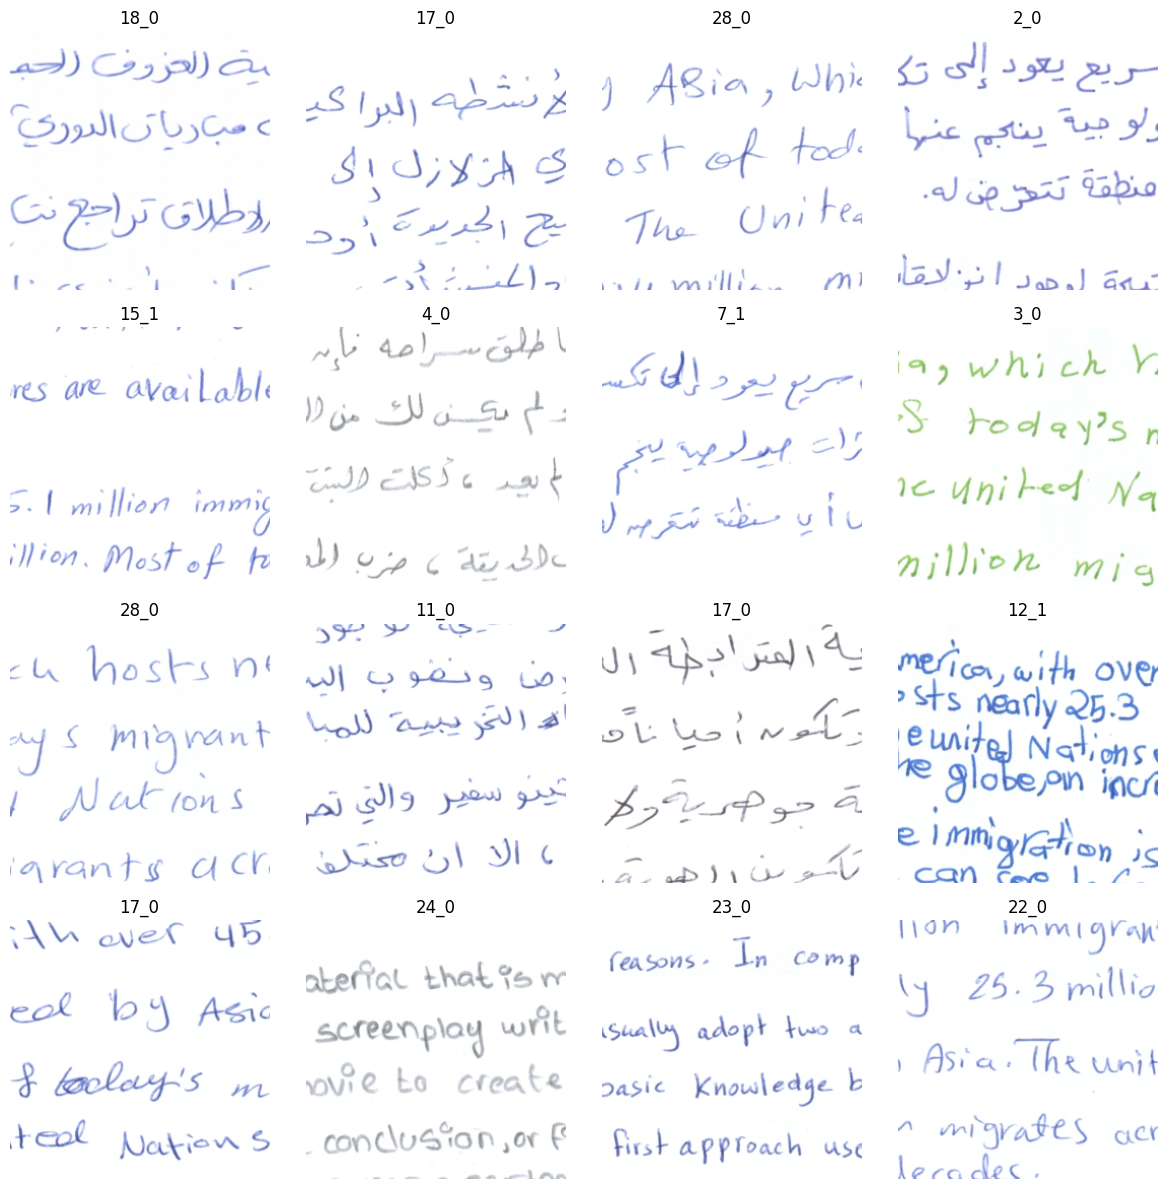

In [86]:
# Create an iterator
data_iter = iter(patch_dataloader)
# Get a single batch
batch = next(data_iter)
show_images(batch['image'], batch['writer'], batch['label'], save_path='batch_patch_images.png')

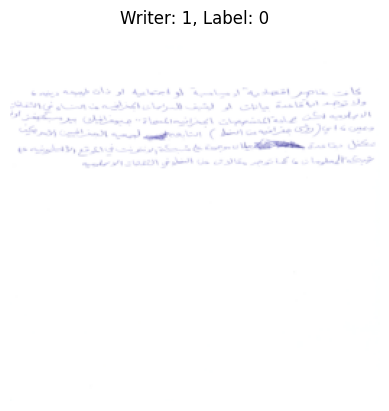

In [69]:
# Function to show a single image
def show_single_image(image, writer, label, save_path=None):
    img = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
    plt.imshow(img)
    plt.title(f'Writer: {writer}, Label: {label}')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()
# Specify the index of the image you want to show
index = 0  # Change this to the index of the image you want to display

# Extract the image, writer, and label from the dataset
sample = example_dataset[index]
image = sample['image']
writer = sample['writer']
label = sample['label']

# Show the single image
show_single_image(image, writer, label,save_path='writer_0.jpg')


## feature extraction

In [74]:
train_FE=train_df_complete.copy()
# Convert the 'language' column to binary columns
language_dummies = pd.get_dummies(train_FE['language'], drop_first=True)

# Add the binary column to the dataframe
train_FE['isEng'] = language_dummies.iloc[:, 0].astype(int)

# Drop the original 'language' column
train_FE.drop(columns=['language'], inplace=True)

In [75]:
# Set the probability of being 0
p_train_FE = 0.9
N_FE=282

# Create a dataframe with writer column from 1 to 282
writers_df = pd.DataFrame({'writer': np.arange(1, N_FE+1)})

# Add a train column that is randomly 0 or 1 with probability p of being 0
writers_df['train'] = np.random.choice([0, 1], size=len(writers_df), p=[1-p_train_FE, p_train_FE])

# Merge with the train_df dataframe on the writer column
train_FE = train_FE.merge(writers_df, on='writer', how='left')

# Display the dataframe
train_FE.head()

,writer,page_id,same_text,tortuosityHist10[0],tortuosityHist10[1],tortuosityHist10[2],tortuosityHist10[3],tortuosityHist10[4],tortuosityHist10[5],tortuosityHist10[6],...,directions_hist1a2a3a4a5a6a7a8a9a10_220[212],directions_hist1a2a3a4a5a6a7a8a9a10_220[213],directions_hist1a2a3a4a5a6a7a8a9a10_220[214],directions_hist1a2a3a4a5a6a7a8a9a10_220[215],directions_hist1a2a3a4a5a6a7a8a9a10_220[216],directions_hist1a2a3a4a5a6a7a8a9a10_220[217],directions_hist1a2a3a4a5a6a7a8a9a10_220[218],directions_hist1a2a3a4a5a6a7a8a9a10_220[219],isEng,train
0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002698,0.002929,0.003014,0.003225,0.003572,0.003957,0.004232,0.004804,0,1
1,1,2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002836,0.002999,0.003246,0.003456,0.003709,0.003994,0.004308,0.004706,0,1
2,1,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002831,0.003078,0.003438,0.003732,0.004100,0.004329,0.004687,0.004879,1,1
3,1,4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003117,0.003441,0.003788,0.004056,0.004285,0.004527,0.004843,0.005085,1,1
4,2,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003079,0.003305,0.003425,0.003403,0.003450,0.003626,0.003977,0.004547,0,1


In [76]:
#i add the sex column
# Merge the file_name column to the train_df dataframe based on the writer column
train_FE = train_FE.merge(sex_df, on=['writer'], how='left')

# Display the updated dataframe
train_FE.head(10)

,writer,page_id,same_text,tortuosityHist10[0],tortuosityHist10[1],tortuosityHist10[2],tortuosityHist10[3],tortuosityHist10[4],tortuosityHist10[5],tortuosityHist10[6],...,directions_hist1a2a3a4a5a6a7a8a9a10_220[213],directions_hist1a2a3a4a5a6a7a8a9a10_220[214],directions_hist1a2a3a4a5a6a7a8a9a10_220[215],directions_hist1a2a3a4a5a6a7a8a9a10_220[216],directions_hist1a2a3a4a5a6a7a8a9a10_220[217],directions_hist1a2a3a4a5a6a7a8a9a10_220[218],directions_hist1a2a3a4a5a6a7a8a9a10_220[219],isEng,train,male
0,1,1,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.002929,0.003014,0.003225,0.003572,0.003957,0.004232,0.004804,0,1,0
1,1,2,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.002999,0.003246,0.003456,0.003709,0.003994,0.004308,0.004706,0,1,0
2,1,3,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003078,0.003438,0.003732,0.004100,0.004329,0.004687,0.004879,1,1,0
3,1,4,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003441,0.003788,0.004056,0.004285,0.004527,0.004843,0.005085,1,1,0
4,2,1,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003305,0.003425,0.003403,0.003450,0.003626,0.003977,0.004547,0,1,0
5,2,2,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003151,0.003247,0.003246,0.003433,0.003516,0.003787,0.004377,0,1,0
6,2,3,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003793,0.004049,0.004214,0.004339,0.004598,0.004874,0.005211,1,1,0
7,2,4,1,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003846,0.004083,0.004329,0.004566,0.004850,0.005092,0.005397,1,1,0
8,3,1,0,1.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.002515,0.002725,0.003046,0.003304,0.003629,0.004037,0.004564,0,0,0
9,3,2,1,0.92875,0.004071,0.001876,0.0,0.018031,0.025427,0.003687,...,0.002550,0.002723,0.002836,0.003049,0.003374,0.003757,0.004354,0,0,0


all columns are numeric and no column has missing values, as expected

In [77]:
# Count numeric columns
num_numeric_cols = train_FE.select_dtypes(include=['number']).shape[1]

# Count columns with missing values
num_missing_cols = train_FE.isnull().any().sum()

# Display results
print(f'Number of numeric columns: {num_numeric_cols}')
print(f'Number of columns with missing values: {num_missing_cols}')

Number of numeric columns: 7072
Number of columns with missing values: 0


In [78]:
target_label='male'
X_train = train_FE[train_FE['train']==1].drop(columns=['writer', 'same_text', 'train',target_label])
y_train = train_FE[train_FE['train']==1][target_label]
X_val = train_FE[train_FE['train']==0].drop(columns=['writer', 'same_text', 'train',target_label])
y_val = train_FE[train_FE['train']==0][target_label]

# model initialization 

In [133]:
selected_model = "resnet18"
N_max=282
use_patches=True

## imagenet pretrained

In [134]:
# New weights with accuracy 80.858%
efficient_model=efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

In [135]:
alexnet_model = alexnet(weights=AlexNet_Weights.DEFAULT)

In [136]:
resnet50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [137]:
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [138]:
# Initialize the Weight Transforms
weights = {"efficient": EfficientNet_V2_S_Weights.IMAGENET1K_V1, 
           "alexnet": AlexNet_Weights.DEFAULT, "resnet50": ResNet50_Weights.DEFAULT, 
           "resnet18": ResNet18_Weights.DEFAULT}

In [139]:
models = {"efficient": efficient_model, "alexnet": alexnet_model, "resnet50": resnet50_model,
          "resnet18": resnet18_model}

In [140]:
for key,model in zip(models.keys(),models.values()):
    print(key)
    num_layers = len(list(model.parameters()))
    print(f"Total Layers: {num_layers}")

    # Print total number of parameters of the model
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params:,}")

efficient
Total Layers: 452
Total Parameters: 21,458,488
alexnet
Total Layers: 16
Total Parameters: 61,100,840
resnet50
Total Layers: 161
Total Parameters: 25,557,032
resnet18
Total Layers: 62
Total Parameters: 11,689,512


## handwriting datasets pretrained

## from scratch end to end

In [32]:
class HandwritingCNN(nn.Module):
    def __init__(self):
        super(HandwritingCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 128)  # Adjust based on image size
        self.fc2 = nn.Linear(128, 2)  # Binary classification (Male/Female)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)  # Flatten for the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 128x128
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # 64x64
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 32x32
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 16x16
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 8x8
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # 4x4
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here; use CrossEntropyLoss during training

        return x


models_scratch = {"efficient": efficientnet_v2_s(weights=None), "alexnet": alexnet(weights=None), "resnet50": resnet50(weights=None),
                  "resnet18": resnet18(weights=None), "handwriting_cnn": HandwritingCNN(), "small_cnn": SmallCNN(num_classes=2)}


## feature extraction models

In [79]:
# Define the model
gbm_classifier = GradientBoostingClassifier(
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=3,  
    random_state=42
)

cat = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42)

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

feature_extraction_model = {'gbm': gbm_classifier, 'cat': cat, 'lgbm': lgbm, 'xgb': xgb}

# experiments

## example image and transformation

In [ ]:
# Load the image
img = Image.open("Tortoise.jpg").convert("RGB")
#img = Image.open("example_text_0035_4.jpg").convert("RGB")

In [126]:
# Apply it to the input image
preprocess = weights["efficient"].transforms()
img_transformed = preprocess(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6051416].


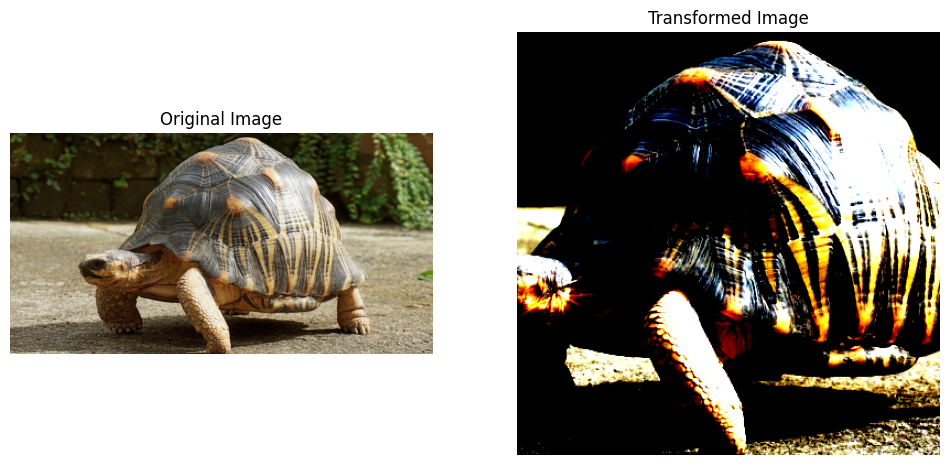

In [127]:
# Plot the original and transformed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Transformed image
transformed_img = img_transformed.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
axes[1].imshow(transformed_img)
axes[1].set_title("Transformed Image")
axes[1].axis('off')

plt.show()

In [131]:
batch = img_transformed.unsqueeze(0)
model=models["efficient"]
model.eval()
# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights["efficient"].meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

terrapin: 47.5%


In [133]:
# Get the top 5 predictions
top5_prob, top5_catid = torch.topk(prediction, 5)

# Print the top 5 categories and their scores
for i in range(top5_prob.size(0)):
    category_name = weights["efficient"].meta["categories"][top5_catid[i]]
    score = top5_prob[i].item()
    print(f"{category_name}: {100 * score:.1f}%")

terrapin: 47.5%
box turtle: 17.4%
mud turtle: 12.3%
leatherback turtle: 1.6%
loggerhead: 0.7%


## Compare models

In [137]:
selected_model="efficient"
model=models[selected_model]
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [138]:
def predict_topk(model, img, weights, topk=5):
    preprocess = weights.transforms()
    img_transformed = preprocess(img)
    batch = img_transformed.unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)
    topk_prob, topk_catid = torch.topk(prediction, topk)
    # Print the top 5 categories and their scores
    for i in range(topk_prob.size(0)):
        category_name = weights.meta["categories"][topk_catid[i]]
        score = topk_prob[i].item()
        print(f"{category_name}: {100 * score:.1f}%")
    return topk_catid

In [139]:
predict_topk(model, img, weights[selected_model], topk=5)

terrapin: 47.5%
box turtle: 17.4%
mud turtle: 12.3%
leatherback turtle: 1.6%
loggerhead: 0.7%


tensor([36, 37, 35, 34, 33])

In [140]:
predict_topk(model, img, weights["resnet50"], topk=5)

box turtle: 63.2%
terrapin: 14.8%
mud turtle: 5.3%
leatherback turtle: 0.4%
loggerhead: 0.3%


tensor([37, 36, 35, 34, 33])

In [141]:
predict_topk(model, img, weights["alexnet"], topk=5)

box turtle: 47.1%
terrapin: 30.9%
mud turtle: 6.0%
leatherback turtle: 0.8%
loggerhead: 0.3%


tensor([37, 36, 35, 34, 33])

# train, validation split (icdar)

I define a custom transform for preprocessing the images for use with the selected models. 

## image preprocessing (transforms)

In [34]:
#print(weights["efficient"].transforms())

In [35]:
#print(weights["resnet18"].transforms())

In [141]:
model_transforms = {}

mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean & std of MNIST
])

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Example: Random horizontal flip
    transforms.RandomRotation(10),      # Example: Random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Example: Color jitter
])

transform_efficient = transforms.Compose([
    transforms.Resize(500,interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
    #weights["efficient"].transforms()
])
model_transforms['efficient']=transform_efficient

if use_patches:
    transform_resnet18 = transforms.Compose([
        transforms.Resize(256,interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
        #weights["efficient"].transforms()
    ])
else:
    transform_resnet18 = transforms.Compose([
        transforms.Resize(500,interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
        #weights["efficient"].transforms()
    ])
model_transforms['resnet18']=transform_resnet18

transform_handwriting_cnn = transforms.Compose([
    transforms.Resize(500,interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
    #weights["efficient"].transforms()
])
model_transforms['handwriting_cnn']=transform_handwriting_cnn


transform_small_cnn = transforms.Compose([
    transforms.Resize(500,interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
    #weights["efficient"].transforms()
])
model_transforms['small_cnn']=transform_small_cnn

In [96]:
print(model_transforms[selected_model])

Compose(
    Resize(size=500, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    ToTensor()
)


## data split

I separate the data in train and validation using the train_df dataframe (i simply need to subset the elements with train=1 or train=0)

In [142]:
if use_patches==False:
    #train_dataset = CustomImageDataset(train_df[train_df['train']==1], transform=model_transforms[selected_model])
    train_dataset = CustomImageDataset(train_df[(train_df['train']==1) & (train_df['writer']<=N_max)] ,
                                    label_column='male', transform=model_transforms[selected_model])
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    #val_dataset = CustomImageDataset(train_df[train_df['train']==0], transform=model_transforms[selected_model])
    val_dataset = CustomImageDataset(train_df[(train_df['train']==0) & (train_df['writer']<=N_max)] ,
                                    label_column='male', transform=model_transforms[selected_model])
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
else:
    train_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==1) & (train_df_expanded['writer']<=N_max)] ,
                                    label_column='male', transform=model_transforms[selected_model])
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    val_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==0) & (train_df_expanded['writer']<=N_max)] ,
                                    label_column='male', transform=model_transforms[selected_model])
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

## inspect preprocessed images

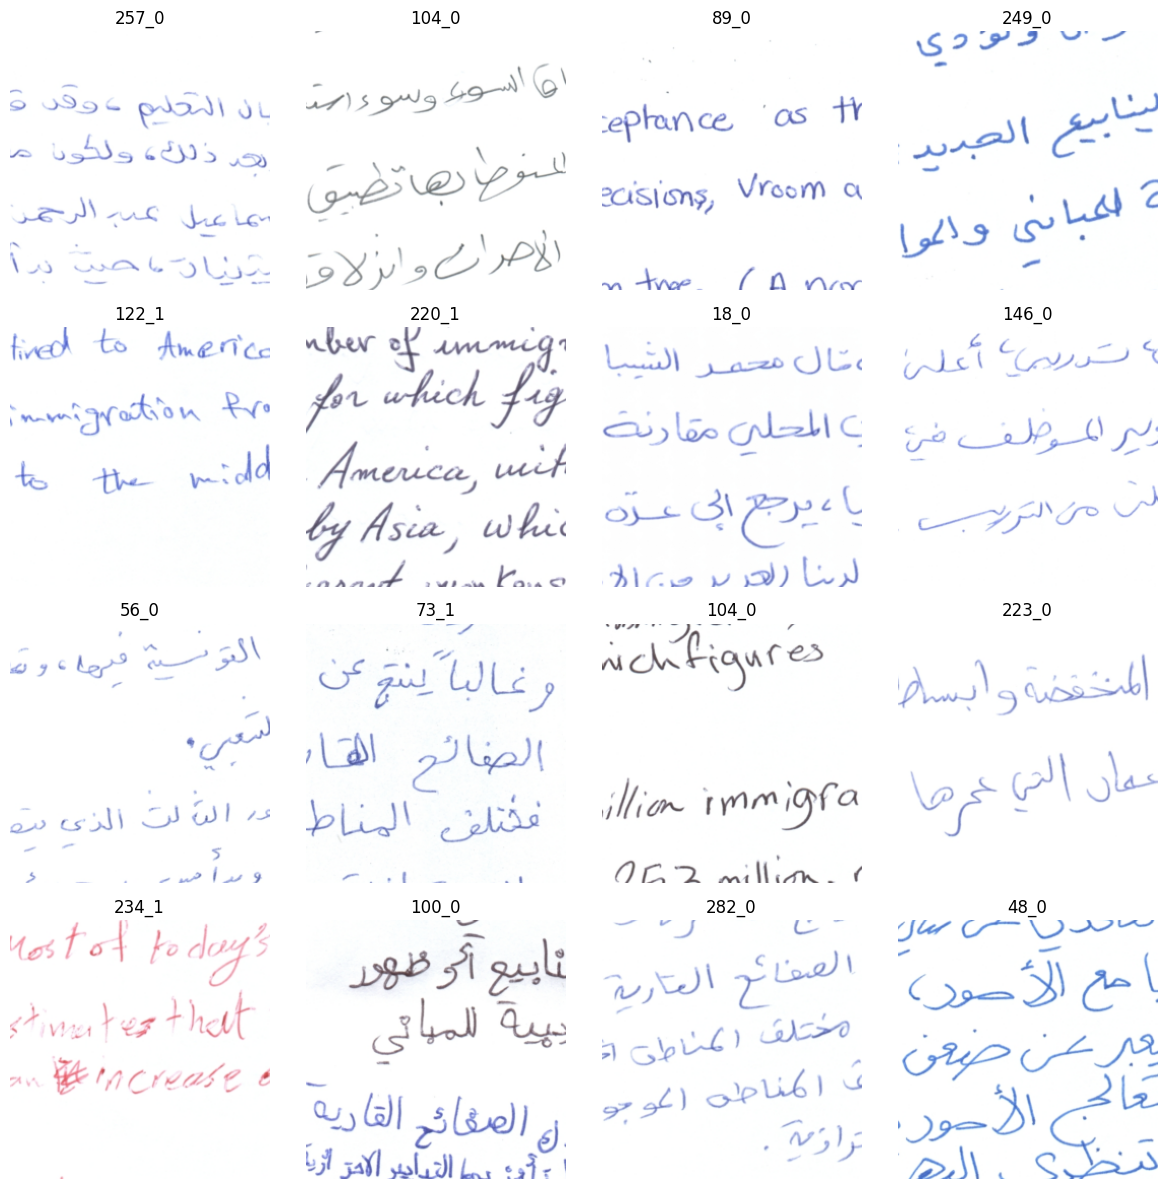

In [143]:
# Create an iterator
data_iter = iter(train_dataloader)
# Get a single batch
batch = next(data_iter)
show_images(batch['image'], batch['writer'], batch['label'], save_path='preprocessed_images.jpg')

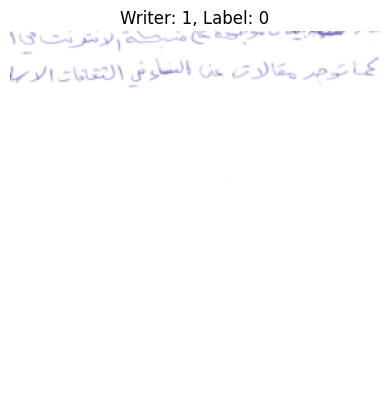

In [156]:
# Specify the index of the image you want to show
index = 0  # Change this to the index of the image you want to display

# Extract the image, writer, and label from the dataset
sample = train_dataset[index]
image = sample['image']
writer = sample['writer']
label = sample['label']

# Show the single image
show_single_image(image, writer, label,save_path='writer_0_preprocessed.jpg')

# dataset preparation (mnist)

In [ ]:
# Load the full MNIST dataset
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split training dataset into train (90%) and validation (10%)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Display a sample image
images, labels = next(iter(train_loader))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.show()

# Print dataset sizes
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# (training) fine tuning approaches

## General definitions

I want to fine tune the pretrained architecture to diagnose. The most straigthforward solution is to freeze a number of layers and update the last layers of the pretrained architecture. I may like to experiment with different "types" of freezing thus i should keep the code general

I need to change the classification head so that it has only two classes (not the N imagenet classes)

What kind of training cycle should I implement? I first want to see what a learning curve with standard parameters looks like. Then I should implement early stopping so that the learning stops at the "optimal" point

how will you structure the code? 1) Include libraries, 2) helper functions and classes, 3) initialization of the model 4) model training, 5) visualizing results

## Training functions definition

In [144]:
#helper functions and classes for this section
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=5, checkpoint_path=None,early_stopping_patience=10, use_scheduler=False):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        # Training Loop
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch['image'], batch['label']
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation Loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch['image'], batch['label']
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = correct / total
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save checkpoint if loss improves
        if checkpoint_path and avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_loss
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
        if use_scheduler:
            scheduler.step()
    
    return model, train_losses, val_losses

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()


def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch['image'], batch['label']
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

#function to get all model layers without repeating layers
def get_all_layers(model):
    layers = []
    for layer in model.children():
        if list(layer.children()):  # If the layer has sub-layers, recurse
            layers.extend(get_all_layers(layer))
        else:
            layers.append(layer)
    return layers


# Assume 'model' is a pre-trained PyTorch model
def fine_tune_last_n_layers(model, n):
    # Print total number of layers of the model
    num_layers = len(list(model.parameters()))
    print(f"Total Layers: {num_layers}")

    # Print total number of parameters of the model
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params:,}")
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Trainable parameters after freezing all layers
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters after freezing: {trainable_params:,}")

    # Unfreeze the last n layers
    layers = get_all_layers(model)
    if len(layers) < n:
        raise ValueError(f"Model has only {len(layers)} layers, but {n} were requested for fine-tuning.")
    print("\n")
    print("Unfreezing the following layers:")
    for layer in layers[-n:]:  # Unfreeze the last n layers
        print(layer)
        for param in layer.parameters():
            param.requires_grad = True
    
    print("\n")
    # Trainable parameters after unfreezing 
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable Parameters after UN-freezing last n layers: {trainable_params:,}")

    return model

In [119]:
def progressive_unfreezing(model,model_name, train_loader,val_loader, 
                           criterion, device, base_lr=1e-3, num_epochs_per_stage=2):
    all_train_losses, all_val_losses = [], []
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    if model_name=='resnet18':
        for param in model.fc.parameters(): #for resnet the last concolutional layer is called fc
            param.requires_grad = True
        # Define optimizer for the classifier only
        optimizer = optim.Adam(model.fc.parameters(), lr=base_lr)
        layer_groups = [model.layer4, model.layer3, model.layer2, model.layer1]  # Deepest to shallowest layers
    else:
        print('model not supported')
        return
    
    print('Step 1: training classification head')
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, 
                                                  optimizer, device, num_epochs=num_epochs_per_stage,
                                                  checkpoint_path='./checkpoints/classifier.pth')
    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)
    print('model on:',next(model.parameters()).device)

    # **Step 2: Unfreeze layers progressively**
    print('Step 2: Unfreeze layers progressively')
    lr = base_lr * 0.1  # Reduce learning rate for deeper layers

    for i,layer in enumerate(layer_groups):
        # Unfreeze the current layer
        for param in layer.parameters():
            param.requires_grad = True  

        # Define new optimizer with unfrozen layers
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Train again with the newly unfrozen layer
        print(f"\nUnfreezing {layer} and training...")
        model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, 
                                                      optimizer, device, num_epochs=num_epochs_per_stage,
                                                      checkpoint_path=f'./checkpoints/fine_tuning_layer_{i}.pth')
        all_train_losses.extend(train_losses)
        all_val_losses.extend(val_losses)
        print('model on:',next(model.parameters()).device)
        # Decrease learning rate for stability
        lr *= 0.1  
    print('fine tuning complete')
    return model, all_train_losses, all_val_losses

## (standard finetuning) Model definition and training 

In [31]:
#cross entropy loss function expects the input to be logits and the labels to be integer values -> 
#it works if I use a 2 class output in which a neuron is for male and one is for female

In [ ]:
# Modify the final classification layer (assuming you have 10 classes)
num_classes = 2  # Change this to match your dataset
num_trainable_layers = 9 # Number of layers to fine-tune -> i am unfreezing two conv layers and the classifier layer
model=models[selected_model]
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# Freeze all layers but the last n
model = fine_tune_last_n_layers(model, num_trainable_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

Device is:  cuda
Total Layers: 452
Total Parameters: 20,180,050
Trainable Parameters after freezing: 0


Unfreezing the following layers:
Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
StochasticDepth(p=0.195, mode=row)
Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
SiLU(inplace=True)
AdaptiveAvgPool2d(output_size=1)
Dropout(p=0.2, inplace=True)
Linear(in_features=1280, out_features=2, bias=True)


Trainable Parameters after UN-freezing last n layers: 726,530


In [96]:
model,train_losses,val_losses = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10: 100%|██████████| 917/917 [1:17:24<00:00,  5.06s/it]


Epoch 1, Train Loss: 0.5829, Train Acc: 0.6897
Epoch 1, Val Loss: 0.7012, Val Acc: 0.6595


Epoch 2/10: 100%|██████████| 917/917 [1:20:41<00:00,  5.28s/it]


Epoch 2, Train Loss: 0.4589, Train Acc: 0.7817
Epoch 2, Val Loss: 0.7492, Val Acc: 0.6458


Epoch 3/10: 100%|██████████| 917/917 [1:16:27<00:00,  5.00s/it]


Epoch 3, Train Loss: 0.3770, Train Acc: 0.8310
Epoch 3, Val Loss: 0.7857, Val Acc: 0.6911


Epoch 4/10: 100%|██████████| 917/917 [1:11:51<00:00,  4.70s/it]


Epoch 4, Train Loss: 0.3351, Train Acc: 0.8507
Epoch 4, Val Loss: 0.8645, Val Acc: 0.6832


Epoch 5/10: 100%|██████████| 917/917 [1:21:07<00:00,  5.31s/it]


Epoch 5, Train Loss: 0.3019, Train Acc: 0.8677
Epoch 5, Val Loss: 1.0237, Val Acc: 0.6170


Epoch 6/10:   5%|▌         | 50/917 [04:41<1:21:15,  5.62s/it]


KeyboardInterrupt: 

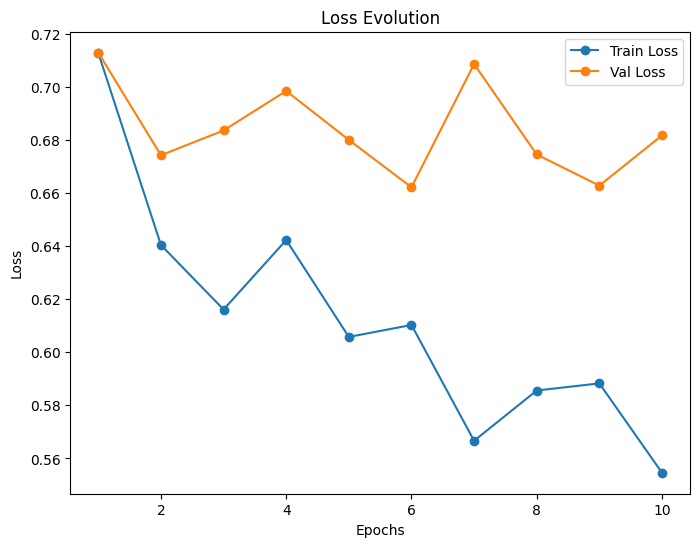

In [97]:
plot_loss(train_losses, val_losses)

In [ ]:
# Example training metadata
training_metadata = {
    "model_name": "ResNet18",
    "epochs": 10,
    "batch_size": 32,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "train_accuracy": 0.92,
    "val_accuracy": 0.88,
    "train_loss": 0.2,
    "val_loss": 0.3,
}

# Save model state_dict and training metadata
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_metadata": training_metadata
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.save(checkpoint, f"{models_path}\model_{selected_model}_{timestamp}.pth")

In [ ]:
# Print total number of layers of the model
num_layers = len(list(model.parameters()))
print(f"Total Layers: {num_layers}")

# Print total number of parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")
summary(model, input_size=(1, 3, 224, 224))  # Adjust input size if needed


Total Parameters: 20,180,050
Trainable Parameters: 20,180,050


Total Layers: 452


ModuleNotFoundError: No module named 'torchinfo'

## (progressive fine tuning) model definition and training

In [120]:
# Modify the final classification layer (assuming you have 10 classes)
num_classes = 2  # Change this to match your dataset
model=models[selected_model]

In [121]:
#the classification head is called fc
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [122]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()


Device is:  cuda


In [123]:
model, train_losses,val_losses = progressive_unfreezing(model,selected_model, train_dataloader,val_dataloader, 
                                                        criterion, device, base_lr=1e-3, num_epochs_per_stage=2)

Step 1: training classification head


Epoch 1/2: 100%|██████████| 78/78 [03:43<00:00,  2.86s/it]


Epoch 1, Train Loss: 0.4339, Train Acc: 0.8146
Epoch 1, Val Loss: 0.4962, Val Acc: 0.7886
Checkpoint saved: ./checkpoints/classifier.pth


Epoch 2/2: 100%|██████████| 78/78 [03:47<00:00,  2.92s/it]


Epoch 2, Train Loss: 0.3118, Train Acc: 0.8826
Epoch 2, Val Loss: 0.4996, Val Acc: 0.7829
model on: cuda:0
Step 2: Unfreeze layers progressively

Unfreezing Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Epoch 1/2: 100%|██████████| 78/78 [03:25<00:00,  2.63s/it]


Epoch 1, Train Loss: 0.3317, Train Acc: 0.8591
Epoch 1, Val Loss: 0.6551, Val Acc: 0.7200
Checkpoint saved: ./checkpoints/fine_tuning_layer_0.pth


Epoch 2/2: 100%|██████████| 78/78 [03:42<00:00,  2.86s/it]


Epoch 2, Train Loss: 0.1544, Train Acc: 0.9490
Epoch 2, Val Loss: 0.7938, Val Acc: 0.6971
model on: cuda:0

Unfreezing Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (co

Epoch 1/2: 100%|██████████| 78/78 [03:42<00:00,  2.85s/it]


Epoch 1, Train Loss: 0.0530, Train Acc: 0.9895
Epoch 1, Val Loss: 0.6589, Val Acc: 0.7600
Checkpoint saved: ./checkpoints/fine_tuning_layer_1.pth


Epoch 2/2: 100%|██████████| 78/78 [03:37<00:00,  2.78s/it]


Epoch 2, Train Loss: 0.0366, Train Acc: 0.9927
Epoch 2, Val Loss: 0.6650, Val Acc: 0.7543
model on: cuda:0

Unfreezing Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv

Epoch 1/2: 100%|██████████| 78/78 [03:41<00:00,  2.84s/it]


Epoch 1, Train Loss: 0.0309, Train Acc: 0.9935
Epoch 1, Val Loss: 0.6793, Val Acc: 0.7543
Checkpoint saved: ./checkpoints/fine_tuning_layer_2.pth


Epoch 2/2: 100%|██████████| 78/78 [03:47<00:00,  2.91s/it]


Epoch 2, Train Loss: 0.0474, Train Acc: 0.9960
Epoch 2, Val Loss: 0.7040, Val Acc: 0.7771
model on: cuda:0

Unfreezing Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
) and training...


Epoch 1/2: 100%|██████████| 78/78 [03:40<00:00,  2.82s/it]


Epoch 1, Train Loss: 0.0374, Train Acc: 0.9935
Epoch 1, Val Loss: 0.6808, Val Acc: 0.7543
Checkpoint saved: ./checkpoints/fine_tuning_layer_3.pth


Epoch 2/2: 100%|██████████| 78/78 [03:36<00:00,  2.78s/it]


Epoch 2, Train Loss: 0.0277, Train Acc: 0.9960
Epoch 2, Val Loss: 0.6777, Val Acc: 0.7657
Checkpoint saved: ./checkpoints/fine_tuning_layer_3.pth
model on: cuda:0
fine tuning complete


In [124]:
# Example training metadata
training_metadata = {
    "model_name": selected_model,
    "epochs": 10,
    "batch_size": 16,
    "learning_rate": 1e-3,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "train_accuracy": 0.9960,
    "val_accuracy": 0.7657,
    "type": "progressive_unfreezing",
    "use_patches": use_patches,
}

# Save model state_dict and training metadata
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_metadata": training_metadata
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.save(checkpoint, f"{models_path}\model_{selected_model}_val077_{timestamp}.pth")

# (training) feature extraction approach

In [ ]:
#feature_extraction_model = {'gbm': gbm_classifier, 'cat': cat, 'lgbm': lgbm, 'xgb': xgb}
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize features
    (selected_model, feature_extraction_model[selected_model])  # Train GBM classifier
])



In [91]:
# Fit the model on training data
pipeline.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
       

In [87]:
# Predict on validation data
y_pred = pipeline.predict(X_val)

# Evaluate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.7286


d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [88]:
# Predict on train data
y_pred = pipeline.predict(X_train)

# Evaluate accuracy
training_accuracy = accuracy_score(y_train, y_pred)
print(f'training Accuracy: {training_accuracy:.4f}')

training Accuracy: 1.0000


d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [89]:
# Example training metadata
metadata = {
    "model_name": selected_model,
    "train_accuracy": training_accuracy,
    "val_accuracy": accuracy
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save model and metadata together
joblib.dump({"model": pipeline, "metadata": metadata}, f"{models_path}\model_{selected_model}_{timestamp}.pkl")

['.\\outputs\\models\\model_lgbm_2025-03-25_14-21-01.pkl']

# (training) CNN from scratch

In [145]:
# Instantiate the model
print(selected_model)
model = models_scratch[selected_model]
#print(model)

# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device is: ",device)
model = model.to(device)

# Loss function & optimizer
#criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

resnet18
Device is:  cuda


In [42]:
# Print total number of layers of the model
num_layers = len(list(model.parameters()))
print(f"Total Layers: {num_layers}")

# Print total number of parameters of the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

Total Layers: 10
Total Parameters: 16,870,721


In [146]:
model,train_losses,val_losses = train_model(model, train_dataloader, val_dataloader, 
                                            criterion, optimizer, device, num_epochs=200,
                                            checkpoint_path='.\checkpoints\scratch_resnet.pth',
                                            early_stopping_patience=10, use_scheduler=True)

Epoch 1/200: 100%|██████████| 155/155 [09:09<00:00,  3.55s/it]


Epoch 1, Train Loss: 1.2347, Train Acc: 0.5061
Epoch 1, Val Loss: 0.7334, Val Acc: 0.5343
Checkpoint saved: .\checkpoints\scratch_resnet.pth


Epoch 2/200: 100%|██████████| 155/155 [08:48<00:00,  3.41s/it]


Epoch 2, Train Loss: 0.7567, Train Acc: 0.5174
Epoch 2, Val Loss: 0.9247, Val Acc: 0.6143


Epoch 3/200: 100%|██████████| 155/155 [09:42<00:00,  3.76s/it]


Epoch 3, Train Loss: 0.6985, Train Acc: 0.5304
Epoch 3, Val Loss: 0.6558, Val Acc: 0.6086
Checkpoint saved: .\checkpoints\scratch_resnet.pth


Epoch 4/200: 100%|██████████| 155/155 [09:02<00:00,  3.50s/it]


Epoch 4, Train Loss: 0.6942, Train Acc: 0.5364
Epoch 4, Val Loss: 0.6990, Val Acc: 0.5057


Epoch 5/200: 100%|██████████| 155/155 [08:48<00:00,  3.41s/it]


Epoch 5, Train Loss: 0.6982, Train Acc: 0.5190
Epoch 5, Val Loss: 3.1310, Val Acc: 0.4571


Epoch 6/200: 100%|██████████| 155/155 [09:22<00:00,  3.63s/it]


Epoch 6, Train Loss: 0.6948, Train Acc: 0.5085
Epoch 6, Val Loss: 0.6629, Val Acc: 0.6200


Epoch 7/200: 100%|██████████| 155/155 [09:12<00:00,  3.56s/it]


Epoch 7, Train Loss: 0.6854, Train Acc: 0.5721
Epoch 7, Val Loss: 0.8318, Val Acc: 0.5343


Epoch 8/200: 100%|██████████| 155/155 [09:45<00:00,  3.78s/it]


Epoch 8, Train Loss: 0.6724, Train Acc: 0.5899
Epoch 8, Val Loss: 0.6873, Val Acc: 0.5600


Epoch 9/200: 100%|██████████| 155/155 [09:53<00:00,  3.83s/it]


Epoch 9, Train Loss: 0.6675, Train Acc: 0.5931
Epoch 9, Val Loss: 0.6606, Val Acc: 0.5657


Epoch 10/200: 100%|██████████| 155/155 [09:38<00:00,  3.73s/it]


Epoch 10, Train Loss: 0.6717, Train Acc: 0.5923
Epoch 10, Val Loss: 0.8382, Val Acc: 0.5600


Epoch 11/200: 100%|██████████| 155/155 [08:14<00:00,  3.19s/it]


Epoch 11, Train Loss: 0.6729, Train Acc: 0.5761
Epoch 11, Val Loss: 8.4870, Val Acc: 0.5429


Epoch 12/200: 100%|██████████| 155/155 [07:54<00:00,  3.06s/it]


Epoch 12, Train Loss: 0.6604, Train Acc: 0.6126
Epoch 12, Val Loss: 0.7327, Val Acc: 0.5486


Epoch 13/200: 100%|██████████| 155/155 [08:08<00:00,  3.15s/it]


Epoch 13, Train Loss: 0.6655, Train Acc: 0.5850
Epoch 13, Val Loss: 0.6388, Val Acc: 0.6429
Checkpoint saved: .\checkpoints\scratch_resnet.pth


Epoch 14/200: 100%|██████████| 155/155 [07:07<00:00,  2.76s/it]


Epoch 14, Train Loss: 0.6557, Train Acc: 0.6235
Epoch 14, Val Loss: 0.7060, Val Acc: 0.4571


Epoch 15/200: 100%|██████████| 155/155 [07:56<00:00,  3.07s/it]


Epoch 15, Train Loss: 0.6555, Train Acc: 0.6053
Epoch 15, Val Loss: 0.7741, Val Acc: 0.4571


Epoch 16/200: 100%|██████████| 155/155 [07:59<00:00,  3.10s/it]


Epoch 16, Train Loss: 0.6568, Train Acc: 0.6130
Epoch 16, Val Loss: 1.8697, Val Acc: 0.5429


Epoch 17/200: 100%|██████████| 155/155 [07:34<00:00,  2.93s/it]


Epoch 17, Train Loss: 0.6548, Train Acc: 0.6198
Epoch 17, Val Loss: 1.4400, Val Acc: 0.5429


Epoch 18/200: 100%|██████████| 155/155 [07:15<00:00,  2.81s/it]


Epoch 18, Train Loss: 0.6442, Train Acc: 0.6283
Epoch 18, Val Loss: 0.7725, Val Acc: 0.4571


Epoch 19/200: 100%|██████████| 155/155 [07:16<00:00,  2.82s/it]


Epoch 19, Train Loss: 0.6434, Train Acc: 0.6219
Epoch 19, Val Loss: 0.7018, Val Acc: 0.5543


Epoch 20/200: 100%|██████████| 155/155 [07:22<00:00,  2.86s/it]


Epoch 20, Train Loss: 0.6262, Train Acc: 0.6518
Epoch 20, Val Loss: 0.5542, Val Acc: 0.7257
Checkpoint saved: .\checkpoints\scratch_resnet.pth


Epoch 21/200: 100%|██████████| 155/155 [07:34<00:00,  2.93s/it]


Epoch 21, Train Loss: 0.6342, Train Acc: 0.6389
Epoch 21, Val Loss: 0.9637, Val Acc: 0.5514


Epoch 22/200: 100%|██████████| 155/155 [07:28<00:00,  2.89s/it]


Epoch 22, Train Loss: 0.6234, Train Acc: 0.6506
Epoch 22, Val Loss: 0.6502, Val Acc: 0.6571


Epoch 23/200: 100%|██████████| 155/155 [08:06<00:00,  3.14s/it]


Epoch 23, Train Loss: 0.6172, Train Acc: 0.6632
Epoch 23, Val Loss: 0.7074, Val Acc: 0.5286


Epoch 24/200: 100%|██████████| 155/155 [07:30<00:00,  2.91s/it]


Epoch 24, Train Loss: 0.6052, Train Acc: 0.6688
Epoch 24, Val Loss: 2.4358, Val Acc: 0.5429


Epoch 25/200: 100%|██████████| 155/155 [07:31<00:00,  2.92s/it]


Epoch 25, Train Loss: 0.6113, Train Acc: 0.6713
Epoch 25, Val Loss: 0.7525, Val Acc: 0.5257


Epoch 26/200: 100%|██████████| 155/155 [07:22<00:00,  2.85s/it]


Epoch 26, Train Loss: 0.5978, Train Acc: 0.6838
Epoch 26, Val Loss: 1.9766, Val Acc: 0.5429


Epoch 27/200: 100%|██████████| 155/155 [07:43<00:00,  2.99s/it]


Epoch 27, Train Loss: 0.5928, Train Acc: 0.6737
Epoch 27, Val Loss: 0.8300, Val Acc: 0.5057


Epoch 28/200: 100%|██████████| 155/155 [07:54<00:00,  3.06s/it]


Epoch 28, Train Loss: 0.5791, Train Acc: 0.6992
Epoch 28, Val Loss: 0.8658, Val Acc: 0.5029


Epoch 29/200: 100%|██████████| 155/155 [07:19<00:00,  2.84s/it]


Epoch 29, Train Loss: 0.5812, Train Acc: 0.7045
Epoch 29, Val Loss: 0.4975, Val Acc: 0.7571
Checkpoint saved: .\checkpoints\scratch_resnet.pth


Epoch 30/200: 100%|██████████| 155/155 [07:23<00:00,  2.86s/it]


Epoch 30, Train Loss: 0.5619, Train Acc: 0.7178
Epoch 30, Val Loss: 0.7637, Val Acc: 0.5714


Epoch 31/200: 100%|██████████| 155/155 [07:52<00:00,  3.05s/it]


Epoch 31, Train Loss: 0.5433, Train Acc: 0.7263
Epoch 31, Val Loss: 0.5894, Val Acc: 0.6771


Epoch 32/200: 100%|██████████| 155/155 [08:00<00:00,  3.10s/it]


Epoch 32, Train Loss: 0.5436, Train Acc: 0.7166
Epoch 32, Val Loss: 0.5973, Val Acc: 0.6714


Epoch 33/200: 100%|██████████| 155/155 [07:36<00:00,  2.95s/it]


Epoch 33, Train Loss: 0.5363, Train Acc: 0.7316
Epoch 33, Val Loss: 0.7746, Val Acc: 0.5771


Epoch 34/200: 100%|██████████| 155/155 [07:44<00:00,  3.00s/it]


Epoch 34, Train Loss: 0.5327, Train Acc: 0.7259
Epoch 34, Val Loss: 0.6242, Val Acc: 0.6714


Epoch 35/200: 100%|██████████| 155/155 [07:28<00:00,  2.89s/it]


Epoch 35, Train Loss: 0.5151, Train Acc: 0.7466
Epoch 35, Val Loss: 1.4717, Val Acc: 0.6000


Epoch 36/200: 100%|██████████| 155/155 [07:58<00:00,  3.08s/it]


Epoch 36, Train Loss: 0.5229, Train Acc: 0.7506
Epoch 36, Val Loss: 2.4283, Val Acc: 0.5429


Epoch 37/200: 100%|██████████| 155/155 [07:44<00:00,  3.00s/it]


Epoch 37, Train Loss: 0.5011, Train Acc: 0.7575
Epoch 37, Val Loss: 0.8130, Val Acc: 0.5343


Epoch 38/200: 100%|██████████| 155/155 [07:41<00:00,  2.98s/it]


Epoch 38, Train Loss: 0.4810, Train Acc: 0.7773
Epoch 38, Val Loss: 0.9450, Val Acc: 0.5057


Epoch 39/200: 100%|██████████| 155/155 [07:52<00:00,  3.05s/it]


Epoch 39, Train Loss: 0.4415, Train Acc: 0.7992
Epoch 39, Val Loss: 0.9642, Val Acc: 0.5086
Early stopping triggered.


In [43]:
# Example training metadata
training_metadata = {
    "model_name": selected_model,
    "epochs": 10,
    "batch_size": 32,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "train_accuracy": 0.5,
    "val_accuracy": 0.39,
}

# Save model state_dict and training metadata
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_metadata": training_metadata
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.save(checkpoint, f"{models_path}\model_{selected_model}_{timestamp}.pth")

# notes

-Adesso sto facendo il resizing delle immagini quando creo il dataloader e anche prima di passare le immagini alla resnet -> come posso riscrivere il codice per fare in un unico passaggio? 

Ho ridimensionato il lato piu' corto di tutte a 256 tenendo l'altro proporzionale. Poi ho usato una custom collate_fn per mantenere le dimensioni delle immagini (il dataloader vuole che in ogni batch tutte le immagini abbiano la stessa dimensione) -> per ogni batch prendo le imamgini piu' piccole e le riscalo alla dimensione dell'immagine piu' grande col padding


- che effetto ha sulla performance del modello riscalare le immagini a 224x224 come richiede resnet50? C'è un modo per mantenere l'aspetto originale? 
posso estrarre delle finestre 224x224 dalle immagini origninali per mantenere la risoluzione (e magari applicare il modello ad ogni finestra e predire sulla base dell'ensemble di predizioni)
posso ridimensionare mantenedo il rapporto di aspetto -> 224xsomething e poi fare padding per ottenere 224x224

- sto assumendo che il pandas dataframe e le immagini estratte dalle cartelle siano in perfetto accordo -> gli scrittori da 1 a 50 sono gli stessi nel pd e nella cartella e hanno lo stesso numero di versioni per scrittore. Dovrei controllare.
